# Install and import necessary libraries

In [2]:
import numpy as np
import tensorflow as tf
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

!pip install opencv-python
import cv2
import os
from tensorflow import keras 
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D ,LeakyReLU

     --------------------------------------- 38.8/38.8 MB 14.5 MB/s eta 0:00:00


In [3]:
IMG_SIZE = (299, 299) # resolution
directory = "data"
BATCH_SIZE = 128
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)

Found 4188 files belonging to 4 classes.
Using 3770 files for training.
Found 4188 files belonging to 4 classes.
Using 418 files for validation.


In [4]:
class_names = train_dataset.class_names
class_names

['Corn___Common_Rust',
 'Corn___Gray_Leaf_Spot',
 'Corn___Healthy',
 'Corn___Northern_Leaf_Blight']

# Data imbalance

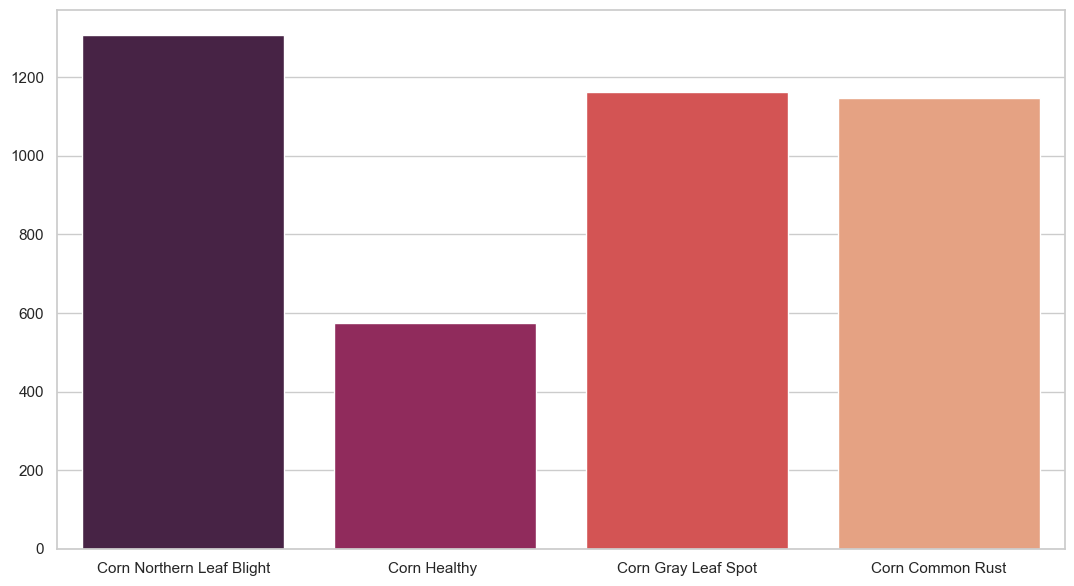

In [5]:
sns.set_theme(style="whitegrid")
Data_imbalance = []
for folder in os.listdir(directory):
    files = gb.glob(pathname=str(directory + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
plt.figure(figsize=(13,7))
sns.barplot(x=["Corn Northern Leaf Blight","Corn Healthy ","Corn Gray Leaf Spot","Corn Common Rust"], y=Data_imbalance, palette="rocket")
plt.show()

In [6]:
total = 0 
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i] 
    
weight_for_0 = (1 / Data_imbalance[0]) * (total / 4.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 4.0)
weight_for_2 = (1 / Data_imbalance[2]) * (total / 4.0)
weight_for_3 = (1 / Data_imbalance[3]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))

Weight for class 0: 0.80
Weight for class 1: 1.82
Weight for class 2: 0.90
Weight for class 3: 0.91


In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

# Corn Common Rust

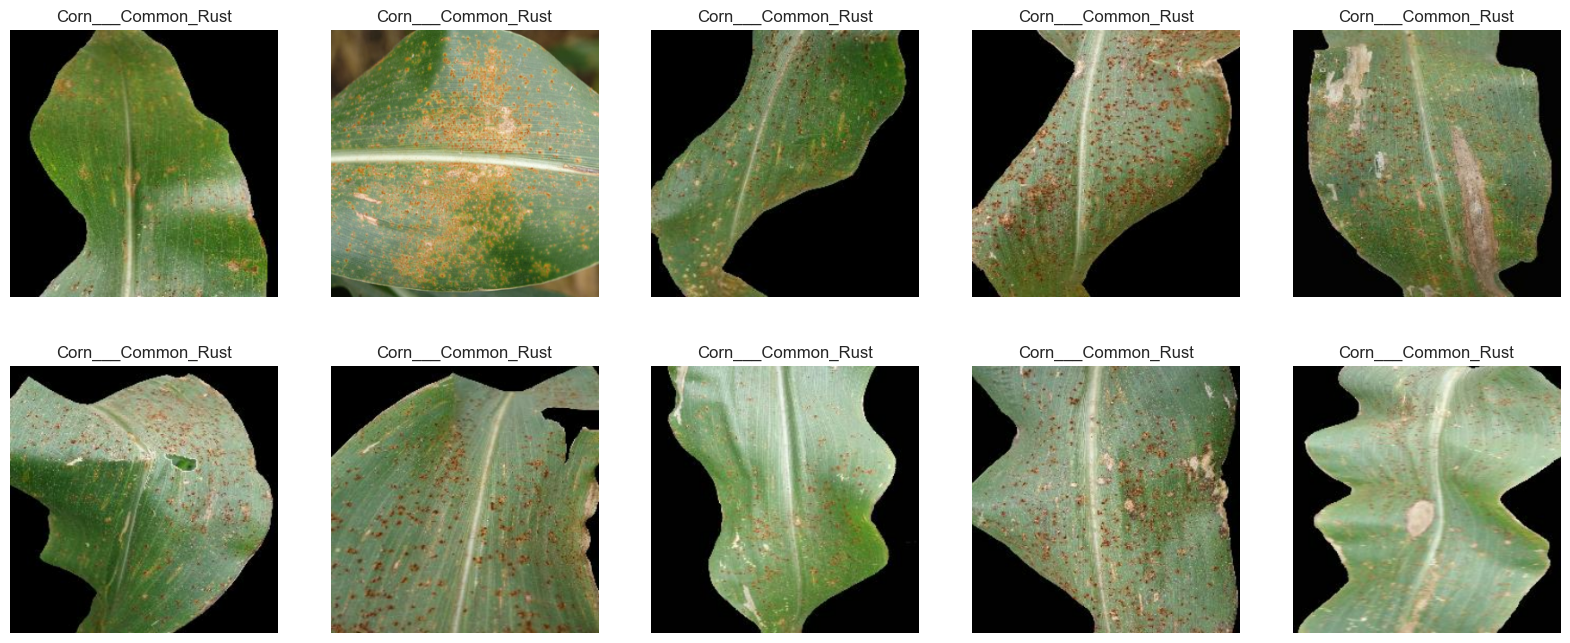

In [9]:
plt.figure(figsize=(20,8))
Common_Rust = []
Gray_Leaf_Spot = []
Corn_Northern_Leaf_Blight =[]
for images , labels in train_dataset.take(1):
    for i in range(100):
        if class_names[labels[i]] == "Corn___Common_Rust":
            Common_Rust.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Corn___Gray_Leaf_Spot":   
            Gray_Leaf_Spot.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Corn___Northern_Leaf_Blight":   
            Corn_Northern_Leaf_Blight.append(images[i].numpy().astype("uint8"))  
for i in range(10):            
    plt.subplot(2,5,i+1)
    plt.imshow(Common_Rust[i])
    plt.axis("off")
    plt.title("Corn___Common_Rust")

# Corn Gray Leaf Spot

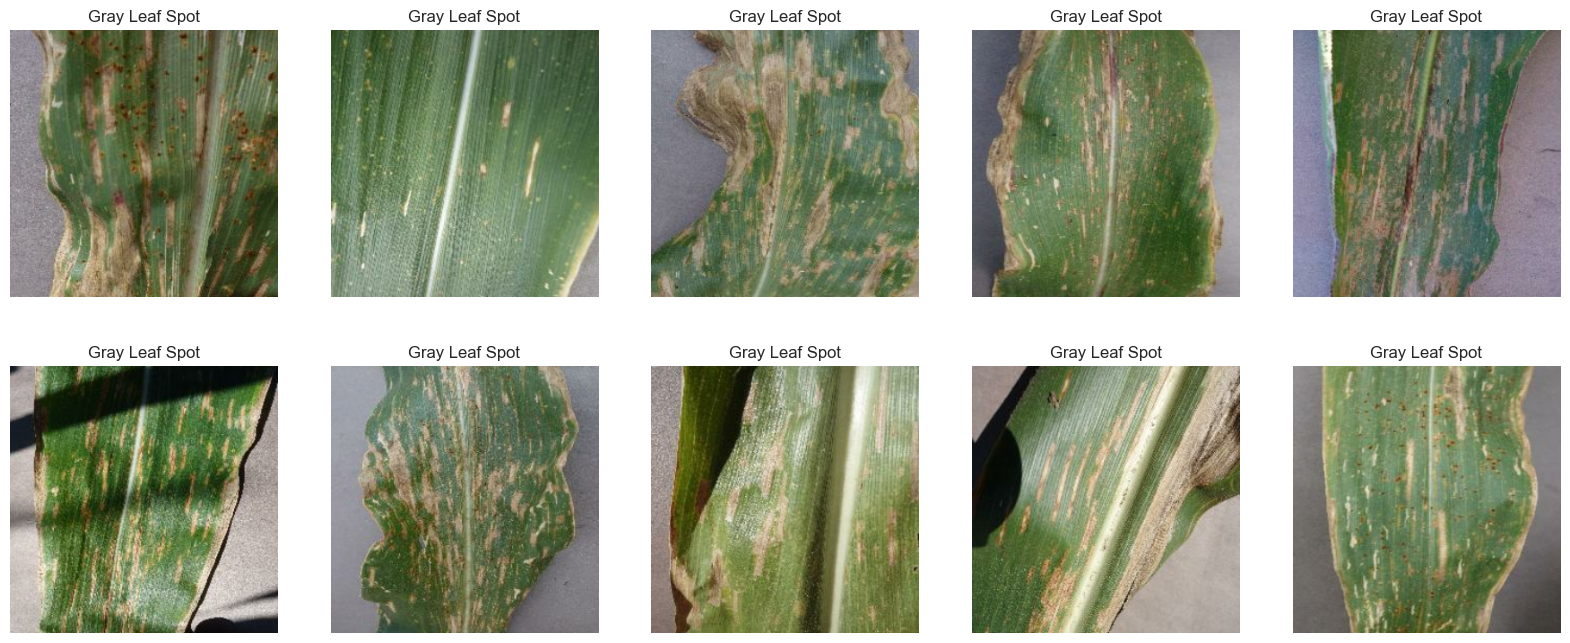

In [10]:
plt.figure(figsize=(20,8))
for i in range(10):            
    plt.subplot(2,5,i+1)
    plt.imshow(Gray_Leaf_Spot[i])
    plt.axis("off")
    plt.title("Gray Leaf Spot")

# Corn Northern Leaf Blight

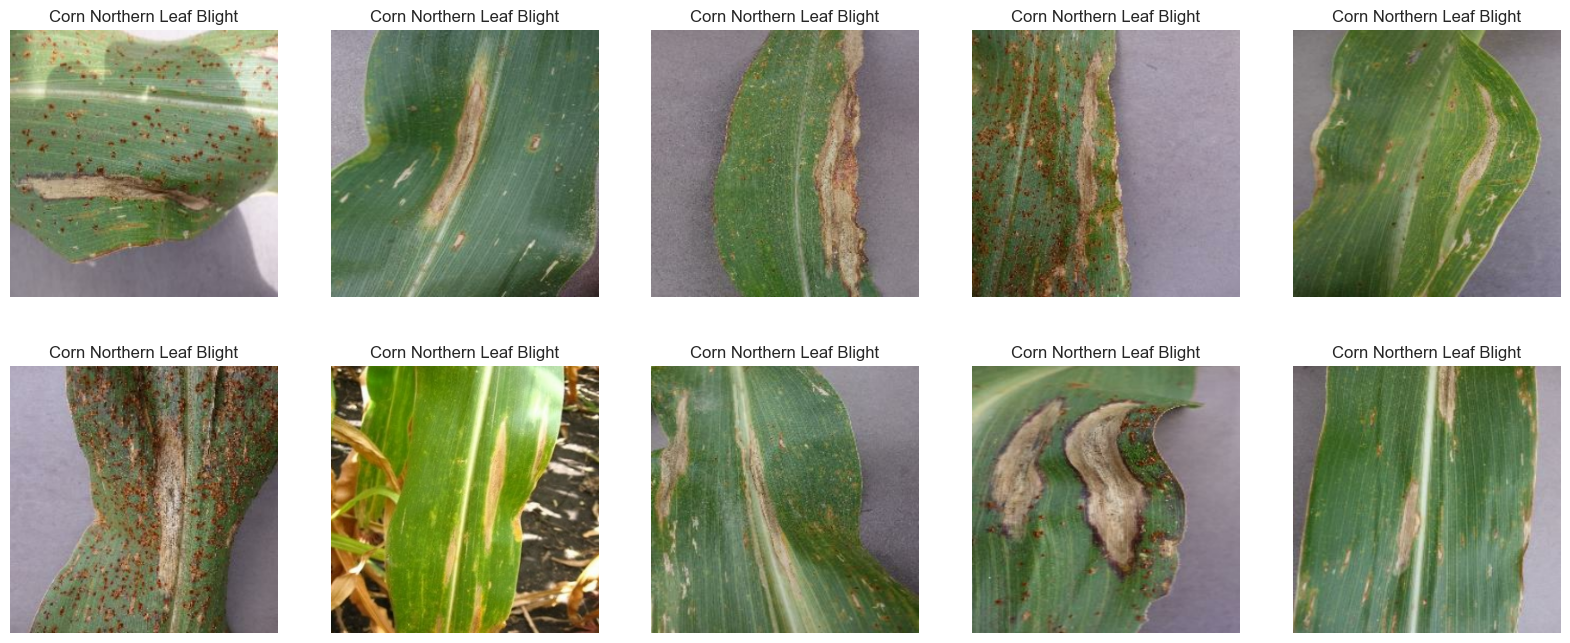

In [11]:
plt.figure(figsize=(20,8))
for i in range(10):            
    plt.subplot(2,5,i+1)
    plt.imshow(Corn_Northern_Leaf_Blight[i])
    plt.axis("off")
    plt.title("Corn Northern Leaf Blight")

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Modeling

In [13]:
IMG_SHAPE = IMG_SIZE +(3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')

87910968/87910968 [==============================] - 7s 0us/step


In [14]:
type(base_model)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [15]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name) 

Numbers of Layers = 311
activation_93
mixed10


In [16]:
# iterate over first batch (32 image) in trainset 
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(128, 8, 8, 2048)


# Inception 

In [17]:
def plant_leaf_model( image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification out of the InceptionV3 model '''
    image_shape = image_shape + (3,)
    
    resnet_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
    resnet_model.trainable = True
    for layer in resnet_model.layers[0 : 291]:
        layer.trainable = False
    
    inputs = tf.keras.Input(image_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = resnet_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(4 ,activation = "softmax") 
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs) 
    model.summary()
    return model

In [18]:
Plant_Leaf_Model = plant_leaf_model(IMG_SIZE)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

# Compiling the model

In [19]:
base_learning_rate = 0.001
Plant_Leaf_Model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

# Training our model

In [20]:
history = Plant_Leaf_Model.fit(train_dataset , verbose=2 , epochs=10 ,class_weight=class_weight,
                               validation_data=validation_dataset , use_multiprocessing= True)

Epoch 1/10
30/30 - 547s - loss: 0.7706 - accuracy: 0.7905 - val_loss: 0.2259 - val_accuracy: 0.9115 - 547s/epoch - 18s/step
Epoch 2/10
30/30 - 553s - loss: 0.2427 - accuracy: 0.9114 - val_loss: 0.1523 - val_accuracy: 0.9402 - 553s/epoch - 18s/step
Epoch 3/10
30/30 - 571s - loss: 0.1366 - accuracy: 0.9570 - val_loss: 0.2587 - val_accuracy: 0.9115 - 571s/epoch - 19s/step
Epoch 4/10
30/30 - 592s - loss: 0.1478 - accuracy: 0.9467 - val_loss: 0.1357 - val_accuracy: 0.9522 - 592s/epoch - 20s/step
Epoch 5/10
30/30 - 576s - loss: 0.0912 - accuracy: 0.9716 - val_loss: 0.1225 - val_accuracy: 0.9498 - 576s/epoch - 19s/step
Epoch 6/10
30/30 - 590s - loss: 0.0947 - accuracy: 0.9676 - val_loss: 0.1171 - val_accuracy: 0.9569 - 590s/epoch - 20s/step
Epoch 7/10
30/30 - 579s - loss: 0.0458 - accuracy: 0.9883 - val_loss: 0.1228 - val_accuracy: 0.9617 - 579s/epoch - 19s/step
Epoch 8/10
30/30 - 588s - loss: 0.0355 - accuracy: 0.9905 - val_loss: 0.1747 - val_accuracy: 0.9522 - 588s/epoch - 20s/step
Epoch 9/

In [21]:
Plant_Leaf_Model.evaluate(validation_dataset , verbose = 1)

4/4 [==============================] - 51s 12s/step - loss: 0.1193 - accuracy: 0.9617


[0.11926818639039993, 0.9617224931716919]

1/1 [==============================] - 0s 225ms/step


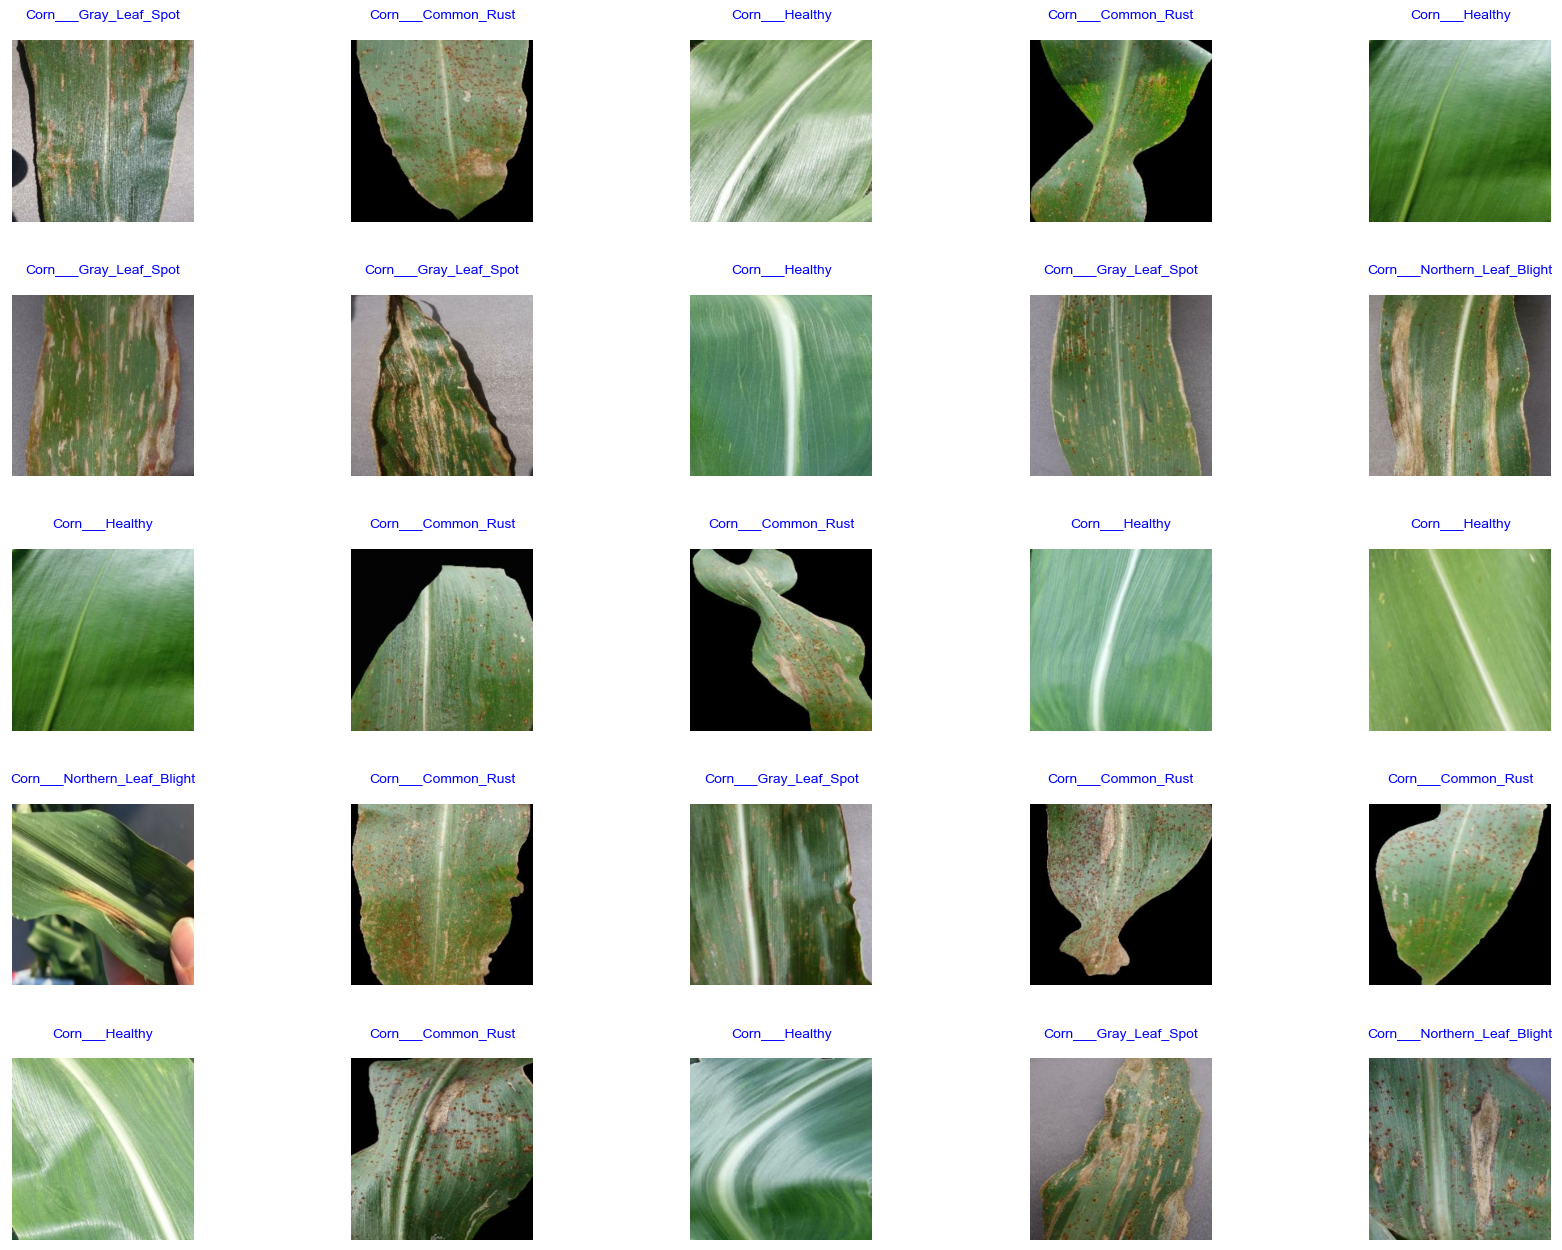

In [22]:
plt.figure(figsize=(20, 15))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = Plant_Leaf_Model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);  
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, 
                            top=0.9, wspace=0.4,hspace=0.4)   

# Plotting Accuracy

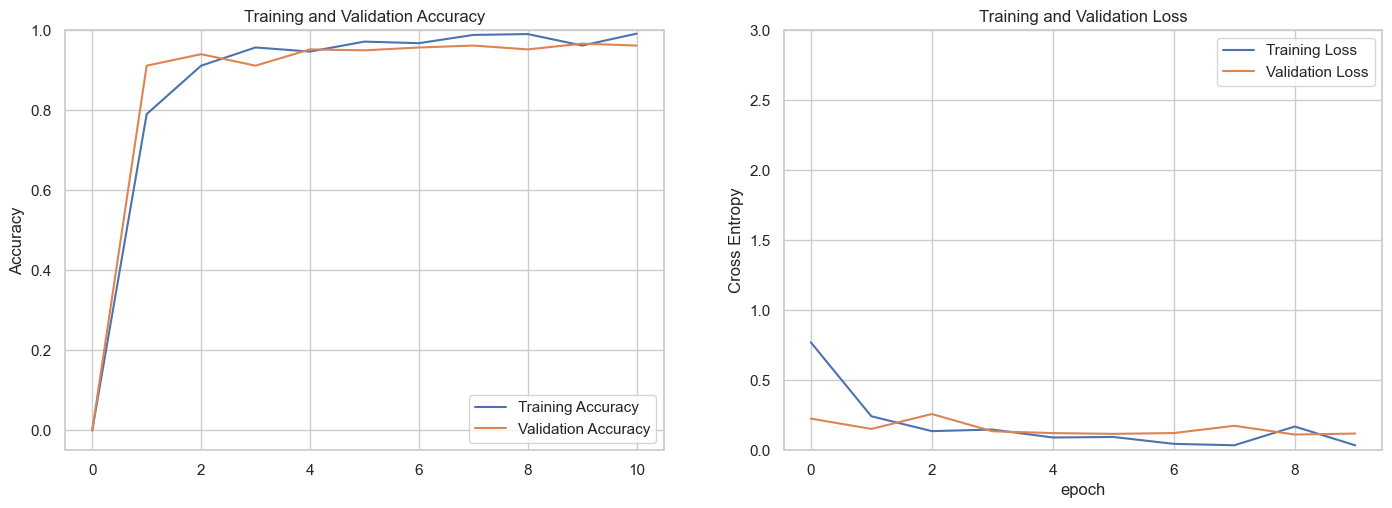

In [23]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout